In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
sns.set(context='talk', style='whitegrid', 
            palette='Set2', font='sans-serif', 
            font_scale=2)
import zipfile, glob, json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime, time
import boto3
import data_processing
import cPickle as pickle
from scipy.stats import scoreatpercentile
from sqlalchemy import create_engine
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, train_test_split
pd.options.display.max_columns = 500
pd.options.display.max_rows = 10000
%matplotlib inline

In [2]:
min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
imputer = preprocessing.Imputer()

In [3]:
df_noaa_import =  pd.read_pickle('../data/noaa/daily/df_noaa_daily.pkl')
df_bart_import = pd.read_pickle('../data/bart/df_bart_hourly.pkl')
df_flu_import = pd.read_csv('../data/flu/google_flu_trends.txt', 
                            parse_dates=['Date'], usecols=['Date','San Francisco, CA'],
                           index_col='Date')

## Feature engineering NOAA daily weather data 

In [4]:
df_noaa_daily = df_noaa_import.copy()

In [5]:
numeric_cols = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 
                'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 
                'AvgSpeed', 'Max5Speed', 'Max5Dir', 'Max2Speed', 'Max2Dir']

for col in numeric_cols:
    df_noaa_daily[col].replace('  T', 0, inplace=True)
    df_noaa_daily[col].replace(' ', 0, inplace=True)
    df_noaa_daily[col] = pd.to_numeric(df_noaa_daily[col], errors='coerce')
#     df_noaa_daily[df_noaa_daily[col].isnull()] = df_noaa_daily[col].mean()

In [6]:
df_noaa_daily.drop(['WBAN', 'YearMonthDay', 'ResultSpeed', 'ResultDir', 'Heat', 'Cool', 'WetBulb',
                    'Max5Speed', 'Max5Dir', 'Max2Speed', 'Max2Dir'], axis=1, inplace=True)

In [7]:
df = df_noaa_daily.copy()

In [8]:
df['dayofweek'] = pd.DatetimeIndex(df.index).weekday
df['dayofyear'] = pd.DatetimeIndex(df.index).dayofyear
df['weekofyear'] = pd.DatetimeIndex(df.index).weekofyear

In [9]:
# df['month'] = pd.DatetimeIndex(df.index).month
# seasons = {1:1,2:2,3:2,4:2,5:3,6:3,
#            7:3,8:4,9:4,10:4,11:1,12:1}
# df["seasons"] = df["month"].map(seasons)

In [10]:
cal = calendar()
holidays = cal.holidays(start=df.index.min(), end=df.index.max())
holidays
df['holiday'] = 0
df.loc[df.index.isin(holidays), 'holiday'] = 1

In [11]:
c = ['Tmin','AvgSpeed', 'DewPoint', 'Tmax','Tavg']
d = ['7']

for col in c:
    for day in d:
        df[col+day] = pd.rolling_mean(df[col], int(day))

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()


In [12]:
c = ['PrecipTotal']
d = ['21']

for col in c:
    for day in d:
        df[col+day] = pd.rolling_sum(df[col], int(day))

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=21,center=False).sum()


In [13]:
c = ['Tmax', 'Tmin','AvgSpeed', 'DewPoint', 'Tavg']
d = ['-2', '-7']

for col in c:
    for day in d:
        df[col+day] = df[col].shift(int(day))

In [14]:
# c = ['Tmin3','AvgSpeed3', 'DewPoint3', 'PrecipTotal3']
# d = ['-1', '-2', '-3']

# for col in c:
#     for day in d:
#         df[col+day] = df[col].shift(int(day))

In [15]:
df[df.columns] = imputer.fit_transform(df[df.columns])

In [16]:
df.ix[29:33]

,Tmax,Tmin,Tavg,DewPoint,PrecipTotal,AvgSpeed,dayofweek,dayofyear,weekofyear,holiday,Tmin7,AvgSpeed7,DewPoint7,Tmax7,Tavg7,PrecipTotal21,Tmax-2,Tmax-7,Tmin-2,Tmin-7,AvgSpeed-2,AvgSpeed-7,DewPoint-2,DewPoint-7,Tavg-2,Tavg-7
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-30,57.0,46.0,52.0,46.0,0.25,9.1,6.0,30.0,4.0,0.0,45.571429,5.014286,45.142857,60.571429,53.285714,0.50,63.0,72.0,45.0,55.0,6.4,8.9,41.0,44.0,54.0,64.0
2011-01-31,56.0,41.0,49.0,44.0,0.00,9.2,0.0,31.0,5.0,0.0,45.285714,5.828571,45.285714,59.571429,52.714286,0.50,62.0,66.0,48.0,48.0,8.7,9.4,28.0,45.0,55.0,57.0
2011-02-01,63.0,45.0,54.0,41.0,0.00,6.4,1.0,32.0,5.0,0.0,45.428571,6.500000,44.857143,58.857143,52.428571,0.46,60.0,60.0,41.0,50.0,3.0,17.0,38.0,30.0,51.0,55.0
2011-02-02,62.0,48.0,55.0,28.0,0.00,8.7,2.0,33.0,5.0,0.0,45.714286,7.371429,42.571429,58.428571,52.285714,0.46,65.0,60.0,42.0,42.0,3.5,6.2,43.0,33.0,54.0,51.0


In [17]:
df.drop(['Tmax', 'Tmin', 'Tavg', 'PrecipTotal'], axis=1, inplace=True)

In [18]:
# df[df.columns] = data_processing.normalize(df[df.columns])

## Load BART hourly data

In [19]:
df_bart_hourly = df_bart_import.copy()

In [20]:
df_bart_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5988240 entries, 2011-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 4 columns):
hour      object
origin    object
exit      object
counts    int64
dtypes: int64(1), object(3)
memory usage: 228.4+ MB


In [21]:
df_bart_hourly.exit.unique()

array(['CC', 'EM', 'MT', 'PL'], dtype=object)

In [22]:
df_bart = df_bart_hourly.ix[datetime.time(5):datetime.time(11)]

In [23]:
df_bart = df_bart.resample('1D', how={'counts': np.sum})

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  if __name__ == '__main__':


In [24]:
df_bart.head()

,counts
date,
2011-01-01,6182.0
2011-01-02,7707.0
2011-01-03,64581.0
2011-01-04,74983.0
2011-01-05,75586.0


In [25]:
upper_limit = df_bart.counts > scoreatpercentile(df_bart.counts, 99)
df_bart[df_bart.counts > scoreatpercentile(df_bart.counts, 99)]

,counts
date,
2012-10-31,177830.0
2014-10-14,113486.0
2014-10-31,137815.0
2015-09-15,115676.0
2015-09-16,114202.0
2015-09-17,113050.0
2015-10-27,114672.0
2015-10-28,112871.0
2015-11-03,112719.0


In [26]:
#trim upper outliers 99 percentile
df_bart[df_bart.counts > scoreatpercentile(df_bart.counts, 99)] = scoreatpercentile(df_bart.counts, 99)

In [27]:
df_bart[upper_limit]

,counts
date,
2012-10-31,112711.25
2014-10-14,112711.25
2014-10-31,112711.25
2015-09-15,112711.25
2015-09-16,112711.25
2015-09-17,112711.25
2015-10-27,112711.25
2015-10-28,112711.25
2015-11-03,112711.25


In [28]:
# low outliers
lower_limit = (df_bart.counts.isnull()) | (df_bart.counts < 4000)
df_bart[(df_bart.counts.isnull()) | (df_bart.counts < 4000)] 

,counts
date,
2011-10-15,NaN
2011-10-16,342.0
2011-11-05,NaN
2011-12-25,3643.0
2012-11-03,NaN
2012-12-25,3737.0
2013-07-01,23.0
2013-07-02,1.0
2013-07-03,NaN


In [29]:
df_bart[(df_bart.counts.isnull()) | (df_bart.counts < 4000)].index #outliers

DatetimeIndex(['2011-10-15', '2011-10-16', '2011-11-05', '2011-12-25',
               '2012-11-03', '2012-12-25', '2013-07-01', '2013-07-02',
               '2013-07-03', '2013-07-04', '2013-07-05', '2013-10-18',
               '2013-10-19', '2013-10-20', '2013-10-21'],
              dtype='datetime64[ns]', name=u'date', freq=None)

In [30]:
impute_dict = {'2012-10-31': 100000, '2011-10-15': 25000, '2011-10-16': 12000, '2011-11-05': 25000, 
'2011-12-25': 4000, '2012-11-03': 12000, '2012-12-25': 4000, 
'2013-07-01': 95000, '2013-07-02': 95000, '2013-07-03': 90000, 
'2013-07-04': 13000, '2013-07-05': 18000, '2013-10-18': 85000,
'2013-10-19': 25000, '2013-10-20': 12000, '2013-10-21': 92000}

In [31]:
for key, val in impute_dict.iteritems():
    df_bart.ix[key]['counts'] = val

In [32]:
df_bart[lower_limit]

,counts
date,
2011-10-15,25000.0
2011-10-16,12000.0
2011-11-05,25000.0
2011-12-25,4000.0
2012-11-03,12000.0
2012-12-25,4000.0
2013-07-01,95000.0
2013-07-02,95000.0
2013-07-03,90000.0


In [33]:
y = df_bart.counts.values
X = range(1,df_bart.counts.shape[0]+1)
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     60.22
Date:                Mon, 09 May 2016   Prob (F-statistic):           1.40e-14
Time:                        17:55:53   Log-Likelihood:                -21673.
No. Observations:                1826   AIC:                         4.335e+04
Df Residuals:                    1824   BIC:                         4.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        5.69e+04   1618.494     35.158      0.000      5.37e+04  6.01e+04
x1            11.9087      1.535      7.760      0.000         8.899    14.918
==============================================================================
Omnibus:                     1856.425   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.856
Skew:                          -0.773   Prob(JB):                     9.40e-65
Kurtosis:                       1.782   Cond. No.                     2.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

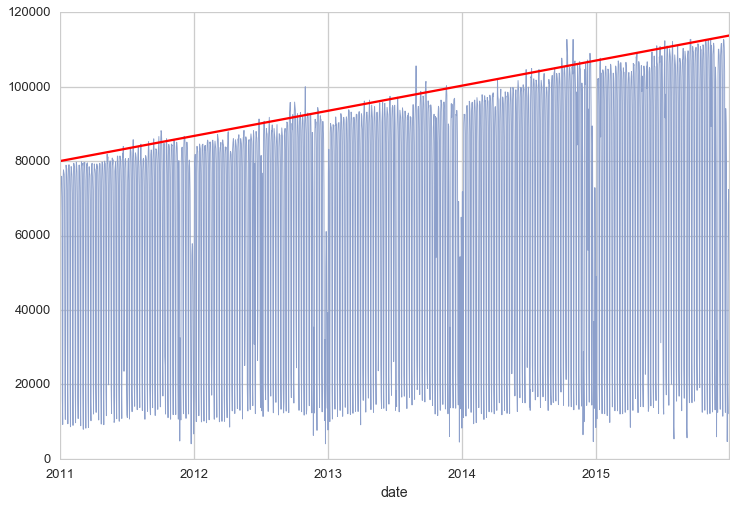

In [34]:
# show trend
sns.set(context='talk', style='whitegrid', 
            palette='Set2', font='sans-serif', 
            font_scale=1, color_codes=False, rc=None)
df_bart.counts.plot(figsize=(12,8), lw=.9, color=sns.color_palette('Set2')[2])
# pd.Series(model.fittedvalues, index=df_bart.index).plot(style='r')
xx = np.arange(1826)
yy = 80000 + xx * 18.5
pd.Series(yy, index=df_bart.index).plot(style='r')
# plt.savefig('../images/normalize_trend.png')

In [35]:
# df_bart['counts_detrend'] = model.resid
# df_bart['counts_detrend'].plot(figsize=(12,8), lw=0.5)

In [36]:
# for x in range(90, 101):
#     print x, scoreatpercentile(df_bart.counts_detrend, x)

In [37]:
# df_bart['counts_normed'] = \
# min_max_scaler.fit_transform(df_bart['counts_detrend'].reshape(-1, 1))

In [38]:
df_bart['counts_normed'] = (df_bart.counts - df_bart.counts.min()) / (yy - df_bart.counts.min())

In [39]:
df_bart.head()

,counts,counts_normed
date,,
2011-01-01,6182.0,0.028711
2011-01-02,7707.0,0.048764
2011-01-03,64581.0,0.796731
2011-01-04,74983.0,0.933305
2011-01-05,75586.0,0.941005


## Flu data

In [40]:
# df_flu_import = df_flu_import.resample('1D', fill_method='ffill')
# df_flu = df_flu_import['20110101':'20150809'].copy()
# df_flu[df_flu.columns] = imputer.fit_transform(df_flu[df_flu.columns])
# df_flu.head()

In [41]:
# df_flu['flu_scaled'] = min_max_scaler.fit_transform(df_flu['San Francisco, CA'].reshape(-1, 1))

In [42]:
# c = ['flu_scaled']
# d = ['7', '-14', '-21']

# for col in c:
#     for day in d:
#         df_flu[col+day] = df_flu[col].shift(int(day))

In [43]:
# df_flu[df_flu.columns] = imputer.fit_transform(df_flu[df_flu.columns])

In [44]:
# df_flu.head(100)

In [45]:
# df = df.merge(df_flu, how='outer', left_index=True, right_index=True)
# df.head()

## Split data into seasons

In [46]:
# df_cold = df.merge(df_bart, how='outer', left_index=True, right_index=True)

In [47]:
# df_cold = df_cold.loc[(df_cold['seasons'] == 1)]

In [49]:
# df_cold = df_cold.loc[(df_cold['seasons'] == 1) | (df_cold['seasons'] == 3)]

## Forecastio data

In [50]:
# df_forecast = pd.read_pickle('../data/forecastio/daily/forecastio_daily-SF.pkl')

In [50]:
engine = create_engine("postgres://postgres@/forecast")
conn = engine.connect()
df_forecast = pd.read_sql("SELECT * FROM forecast_daily", con=engine)
conn.close()
engine.dispose()

In [51]:
df_forecast.head()

,apparenttemperaturemax,apparenttemperaturemin,precipintensity,precipintensitymax,pressure,temperaturemax,temperaturemin,time,windspeed
0,76.39,57.49,NaN,NaN,1012.16,76.39,57.49,1283324400,3.61
1,72.17,58.39,NaN,NaN,1010.58,72.17,58.39,1283410800,3.65
2,63.18,54.70,NaN,NaN,1014.33,63.18,54.70,1283497200,4.78
3,58.50,53.59,NaN,NaN,1014.00,58.50,53.59,1283583600,4.75
4,64.29,54.00,NaN,NaN,1010.26,64.29,54.00,1283670000,4.60


In [52]:
# df_forecast.drop(['apparenttemperaturemaxtime',
# 'apparenttemperaturemintime', 'cloudcover',
# 'dewpoint', 'humidity', 'icon', 'moonphase', 'ozone',
# 'precipintensitymaxtime', 'precipintensitymax', 'precipintensity',
# 'precipprobability', 'preciptype',  'summary', 'temperaturemin',
# 'sunrisetime', 'sunsettime',  'temperaturemaxtime', 'temperaturemax',
# 'temperaturemintime',  'visibility', 'windbearing'], axis=1, inplace=True)

In [53]:
# df_forecast.columns = [x.lower() for x in df_forecast.columns]

In [54]:
# df = df_forecast.copy()

In [55]:
df = data_processing.clean_data(df_forecast)

data_processing.py:39: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  df = df.resample('1D', how='mean')
data_processing.py:60: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  df[col+day] = pd.rolling_mean(df[col], int(day))


In [56]:
df.head()

,apparenttemperaturemax,apparenttemperaturemin,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,holiday,apparenttemperaturemax7,apparenttemperaturemin7,temperaturemax7,temperaturemin7,apparenttemperaturemax-3,apparenttemperaturemax-7,apparenttemperaturemin-3,apparenttemperaturemin-7,windspeed-3,windspeed-7
time,,,,,,,,,,,,,,,,,,,,
2010-09-01,76.39,57.49,1012.16,76.39,57.49,3.61,2,244,35,0,0.0,0.0,0.0,0.0,58.50,59.50,53.59,56.10,4.75,9.42
2010-09-02,72.17,58.39,1010.58,72.17,58.39,3.65,3,245,35,0,0.0,0.0,0.0,0.0,64.29,60.89,54.00,53.60,4.60,5.22
2010-09-03,63.18,54.70,1014.33,63.18,54.70,4.78,4,246,35,0,0.0,0.0,0.0,0.0,71.37,65.79,55.99,54.29,4.15,3.79
2010-09-04,58.50,53.59,1014.00,58.50,53.59,4.75,5,247,35,0,0.0,0.0,0.0,0.0,60.30,70.00,54.59,54.79,9.18,4.17
2010-09-05,64.29,54.00,1010.26,64.29,54.00,4.60,6,248,35,0,0.0,0.0,0.0,0.0,59.50,58.79,56.10,52.80,9.42,6.46


In [78]:
# df['time'] = pd.to_datetime(df['time'], unit='s')

In [79]:
# df.set_index('time', inplace=True)

In [14]:
# df = df.resample('1D', how='mean')

In [367]:
# df['dayofweek'] = pd.DatetimeIndex(df.index).weekday
# df['dayofyear'] = pd.DatetimeIndex(df.index).dayofyear
# df['weekofyear'] = pd.DatetimeIndex(df.index).weekofyear

In [57]:
# df['month'] = pd.DatetimeIndex(df.index).month
# seasons = {1:1,2:2,3:2,4:2,5:3,6:3,
#            7:3,8:4,9:4,10:4,11:1,12:1}
# df["seasons"] = df["month"].map(seasons)

In [58]:
# cal = calendar()
# holidays = cal.holidays(start=df.index.min(), end=df.index.max())
# holidays
# df['holiday'] = 0
# df.loc[df.index.isin(holidays), 'holiday'] = 1

In [59]:
df.columns

Index([  u'apparenttemperaturemax',   u'apparenttemperaturemin',
                       u'pressure',           u'temperaturemax',
                 u'temperaturemin',                u'windspeed',
                      u'dayofweek',                u'dayofyear',
                     u'weekofyear',                  u'holiday',
        u'apparenttemperaturemax7',  u'apparenttemperaturemin7',
                u'temperaturemax7',          u'temperaturemin7',
       u'apparenttemperaturemax-3', u'apparenttemperaturemax-7',
       u'apparenttemperaturemin-3', u'apparenttemperaturemin-7',
                    u'windspeed-3',              u'windspeed-7'],
      dtype='object')

In [371]:
# c = ['apparenttemperaturemax','apparenttemperaturemin', 
#      'pressure', 'windspeed']
# d = ['7']

# for col in c:
#     for day in d:
#         df[col+day] = pd.rolling_mean(df[col], int(day))

In [372]:
# c = ['apparenttemperaturemax','apparenttemperaturemin', 
#      'windspeed']
# d = ['-3', '-7']

# for col in c:
#     for day in d:
#         df[col+day] = df[col].shift(int(day))

In [301]:
# df.fillna(0, inplace=True)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2085 entries, 2010-09-01 to 2016-05-16
Freq: D
Data columns (total 20 columns):
apparenttemperaturemax      2085 non-null float64
apparenttemperaturemin      2085 non-null float64
pressure                    2085 non-null float64
temperaturemax              2085 non-null float64
temperaturemin              2085 non-null float64
windspeed                   2085 non-null float64
dayofweek                   2085 non-null int32
dayofyear                   2085 non-null int32
weekofyear                  2085 non-null int32
holiday                     2085 non-null int64
apparenttemperaturemax7     2085 non-null float64
apparenttemperaturemin7     2085 non-null float64
temperaturemax7             2085 non-null float64
temperaturemin7             2085 non-null float64
apparenttemperaturemax-3    2085 non-null float64
apparenttemperaturemax-7    2085 non-null float64
apparenttemperaturemin-3    2085 non-null float64
apparenttemperaturemin-7 

In [61]:
# df.drop(['apparenttemperaturemax', 'apparenttemperaturemin', 
#          'precipintensity', 'precipintensitymax'],
#        axis = 1, inplace=True)

In [62]:
df.head()

,apparenttemperaturemax,apparenttemperaturemin,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,holiday,apparenttemperaturemax7,apparenttemperaturemin7,temperaturemax7,temperaturemin7,apparenttemperaturemax-3,apparenttemperaturemax-7,apparenttemperaturemin-3,apparenttemperaturemin-7,windspeed-3,windspeed-7
time,,,,,,,,,,,,,,,,,,,,
2010-09-01,76.39,57.49,1012.16,76.39,57.49,3.61,2,244,35,0,0.0,0.0,0.0,0.0,58.50,59.50,53.59,56.10,4.75,9.42
2010-09-02,72.17,58.39,1010.58,72.17,58.39,3.65,3,245,35,0,0.0,0.0,0.0,0.0,64.29,60.89,54.00,53.60,4.60,5.22
2010-09-03,63.18,54.70,1014.33,63.18,54.70,4.78,4,246,35,0,0.0,0.0,0.0,0.0,71.37,65.79,55.99,54.29,4.15,3.79
2010-09-04,58.50,53.59,1014.00,58.50,53.59,4.75,5,247,35,0,0.0,0.0,0.0,0.0,60.30,70.00,54.59,54.79,9.18,4.17
2010-09-05,64.29,54.00,1010.26,64.29,54.00,4.60,6,248,35,0,0.0,0.0,0.0,0.0,59.50,58.79,56.10,52.80,9.42,6.46


## Random Forest

In [73]:
df_train = df.copy()

In [74]:
# y = df_bart.counts_normed.values
# X = df_train.values

In [75]:
y = df_bart['20110101':'20151231'].counts_normed.values
X = df_train['20110101':'20151231'].values

In [76]:
y2 = df_bart['20110101':'20151231'].counts_normed.values
X2 = df_train['20110101':'20151231'][['dayofweek','holiday','dayofyear']].values

In [77]:
# df_train = df_cold['20110201':'20151231'].copy()
# y = df_train['counts_normed'].values
# df_train.drop(['counts', 'counts_normed'], axis=1, inplace=True)
# X = df_train.values

In [78]:
# model trained with weather data
rf = RandomForestRegressor(100, n_jobs=-1)
rf.fit(X,y)

# model without weather data
rf2 = RandomForestRegressor(100, n_jobs=-1)
rf2.fit(X2,y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [79]:
cross_val_score(rf, X, y, cv=5).mean()

0.965934720112681

In [80]:
cross_val_score(rf2, X2, y2, cv=5).mean()

0.97959053539192098

In [67]:
# df_cold.columns

In [68]:
# y = df_cold['20110101':'20151231'].counts_normed.values
# df_cold2 = df_cold['20110101':'20151231'][['pressure','temperaturemax','temperaturemin', 'windspeed',
# 'dayofweek','dayofyear','weekofyear', 'holiday',
#        'apparenttemperaturemax-3', 'apparenttemperaturemax-7',
#        'apparenttemperaturemin-3', 'apparenttemperaturemin-7',
#                     'windspeed-3',              'windspeed-7']]
# X = df_cold2.values

In [69]:
# y2 = df_cold['20110101':'20151231'].counts_normed.values
# X2 = df_cold['20110101':'20151231'][['dayofweek','holiday','dayofyear']].values

In [81]:
# model trained with weather data
rf = RandomForestRegressor(100, n_jobs=-1)
rf.fit(X,y)

# model without weather data
rf2 = RandomForestRegressor(100, n_jobs=-1)
rf2.fit(X2,y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [82]:
cross_val_score(rf, X, y, cv=10).mean()

0.96511325096519918

In [83]:
cross_val_score(rf2, X2, y2, cv=10).mean()

0.97892194149791545

In [94]:
# df_cold

In [84]:
feat_rank = np.argsort(rf.feature_importances_)[::-1]
feat_rank

array([ 6,  9,  7,  2,  8, 16, 17, 19, 15,  5,  0, 10,  3, 14,  1, 18, 12,
       11,  4, 13])

In [85]:
df_features = pd.DataFrame(rf.feature_importances_,df_train.columns, columns = ['feature_value'])
df_features.sort_values('feature_value', ascending=False)

,feature_value
dayofweek,0.858810
holiday,0.082344
dayofyear,0.026860
pressure,0.005266
weekofyear,0.003984
apparenttemperaturemin-3,0.003441
apparenttemperaturemin-7,0.002992
windspeed-7,0.002535
apparenttemperaturemax-7,0.002092
windspeed,0.001937


In [97]:
# df_cold['predict'] = rf.predict(X)
# df_cold.head()

In [98]:
scores = np.zeros((feat_rank.shape[0],2))
for i in range(1,feat_rank.shape[0]+1):
    features = [df.columns[feat_rank][x] for x in range(i)]
    scores[i-1:] = (i,(cross_val_score(rf, X, y, cv=10)).mean())
scores

array([[  1.        ,   0.9650921 ],
       [  2.        ,   0.96475383],
       [  3.        ,   0.96570907],
       [  4.        ,   0.96483213],
       [  5.        ,   0.9658616 ],
       [  6.        ,   0.96503486],
       [  7.        ,   0.96508708],
       [  8.        ,   0.96547167],
       [  9.        ,   0.96580433],
       [ 10.        ,   0.96517982],
       [ 11.        ,   0.96428705],
       [ 12.        ,   0.96459107],
       [ 13.        ,   0.96551823],
       [ 14.        ,   0.96532787],
       [ 15.        ,   0.96449927],
       [ 16.        ,   0.96477862],
       [ 17.        ,   0.96414641],
       [ 18.        ,   0.9652343 ],
       [ 19.        ,   0.96450723],
       [ 20.        ,   0.96474922]])

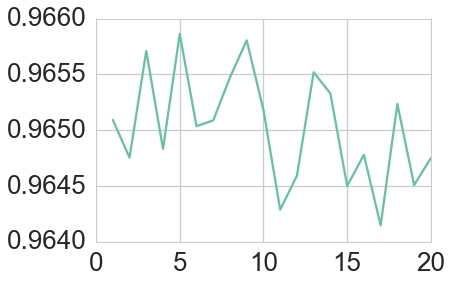

In [99]:
plt.plot(scores[:,:1],scores[:,1:2])

In [86]:
features = [df_train.columns[feat_rank][x] for x in range(5)]
features

['dayofweek', 'holiday', 'dayofyear', u'pressure', 'weekofyear']

In [87]:
cross_val_score(rf, X, y, cv=5).mean()

0.96481721030990886

In [88]:
df_train = df[features]
df_train.head()

,dayofweek,holiday,dayofyear,pressure,weekofyear
time,,,,,
2010-09-01,2,0,244,1012.16,35
2010-09-02,3,0,245,1010.58,35
2010-09-03,4,0,246,1014.33,35
2010-09-04,5,0,247,1014.00,35
2010-09-05,6,0,248,1010.26,35


In [89]:
df_train.shape

(2085, 5)

In [90]:
X = df_train['20110101':'20151231'].values

In [91]:
df_train.columns

Index([u'dayofweek', u'holiday', u'dayofyear', u'pressure', u'weekofyear'], dtype='object')

In [92]:
# X = df_train[features]

In [93]:
rf = RandomForestRegressor(100, n_jobs=-1)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [94]:
feat_rank = np.argsort(rf.feature_importances_)[::-1]
feat_rank

array([0, 1, 2, 3, 4])

In [95]:
df_features = pd.DataFrame(rf.feature_importances_,df_train[features].columns, columns = ['feature_value'])
df_features.sort_values('feature_value', ascending=False)

,feature_value
dayofweek,0.860339
holiday,0.081764
dayofyear,0.040008
pressure,0.009518
weekofyear,0.008371


In [96]:
cross_val_score(rf, X, y, cv=5).mean()

0.97681239470748982

In [110]:
scores = np.zeros((feat_rank.shape[0],2))
for i in range(1,feat_rank.shape[0]+1):
    features = [df_train.columns[feat_rank][x] for x in range(i)]
    scores[i-1:] = (i,(cross_val_score(rf, X, y, cv=5)).mean())
scores   

array([[ 1.        ,  0.97423807],
       [ 2.        ,  0.97476094],
       [ 3.        ,  0.97458202],
       [ 4.        ,  0.97505158],
       [ 5.        ,  0.97512357]])

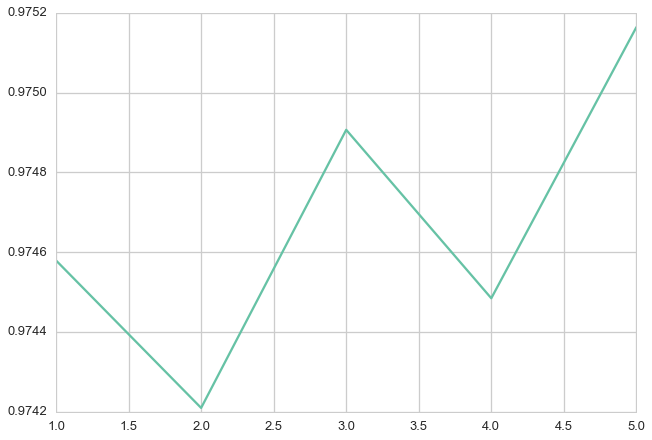

In [69]:
plt.plot(scores[:,:1],scores[:,1:2])

## Calculate Slack and Energy Savings

In [109]:
df = df['20110101':'20151231']

In [110]:
df_predict = df.merge(df_bart, how='outer', left_index=True, right_index=True)

In [111]:
df_predict['predict'] = rf.predict(X)

In [112]:
df_predict['slack'] = 1 - df_predict['counts_normed'] 

In [113]:
df_predict[(df_predict.holiday == 0) & (df_predict.dayofweek <= 4)]['slack'].mean()

0.07321109226562382

In [114]:
df_predict[df_predict.dayofweek <= 4]['slack'].mean()

0.09785337061082469

In [115]:
df_predict['20150101':'20151231'][(df_predict.holiday == 0) & (df_predict.dayofweek <= 4)]['slack'].mean()

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


0.07373642232314127

In [116]:
df_predict['slack'].mean()

0.31283401516392084

In [117]:
df_predict[(df_predict.holiday == 0) & (df_predict.dayofweek <= 4)]

,apparenttemperaturemax,apparenttemperaturemin,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,holiday,apparenttemperaturemax7,apparenttemperaturemin7,temperaturemax7,temperaturemin7,apparenttemperaturemax-3,apparenttemperaturemax-7,apparenttemperaturemin-3,apparenttemperaturemin-7,windspeed-3,windspeed-7,counts,counts_normed,predict,slack
time,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,51.00,41.08,1018.79,51.00,46.00,7.24,0,3,1,0,49.961429,40.734286,51.285714,45.144286,43.26,42.26,31.70,34.88,14.43,7.46,64581.00,0.796731,0.835015,0.203269
2011-01-04,52.00,37.86,1024.54,52.00,43.00,7.97,1,4,1,0,49.461429,39.332857,50.785714,44.172857,41.15,43.09,33.28,38.35,7.67,8.27,74983.00,0.933305,0.930417,0.066695
2011-01-05,53.00,38.82,1026.22,53.00,45.00,8.17,2,5,1,0,49.061429,39.131429,50.385714,44.087143,43.38,53.00,35.93,41.70,5.04,7.65,75586.00,0.941005,0.938368,0.058995
2011-01-06,43.26,31.70,1023.45,48.00,40.00,14.43,3,6,1,0,47.884286,38.064286,49.885714,43.687143,45.00,54.00,33.78,46.17,4.52,0.69,75930.00,0.945297,0.941344,0.054703
2011-01-07,41.15,33.28,1019.98,43.00,40.00,7.67,4,7,1,0,47.137143,37.335714,49.185714,43.442857,42.26,56.00,34.88,51.00,7.46,3.17,70277.00,0.870794,0.866668,0.129206
2011-01-10,42.26,34.88,1022.50,47.00,40.00,7.46,0,10,2,0,45.721429,35.178571,47.571429,41.285714,54.00,51.00,46.17,43.51,0.69,5.67,75421.00,0.937696,0.941021,0.062304
2011-01-11,43.09,38.35,1022.52,47.00,44.00,8.27,1,11,2,0,44.448571,35.248571,46.857143,41.428571,56.00,58.00,51.00,41.94,3.17,5.96,77661.00,0.966870,0.961441,0.033130
2011-01-12,53.00,41.70,1027.02,53.00,47.00,7.65,2,12,2,0,44.448571,35.660000,46.857143,41.714286,60.00,57.00,49.00,50.00,2.28,2.64,77080.00,0.959011,0.952695,0.040989
2011-01-13,54.00,46.17,1028.32,54.00,49.00,0.69,3,13,2,0,45.982857,37.727143,47.714286,43.000000,53.00,58.00,42.00,48.42,6.21,4.35,76401.00,0.949870,0.954597,0.050130


### Train Test Split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.4, random_state=1)

In [112]:
rf_train = RandomForestRegressor(40, n_jobs=-1)
rf_train.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [113]:
rf_train.score(X_test, y_test)

0.96937920292309177

## Analysis

In [119]:
df_bart

,counts,counts_normed
date,,
2011-01-01,6182.00,0.028711
2011-01-02,7707.00,0.048764
2011-01-03,64581.00,0.796731
2011-01-04,74983.00,0.933305
2011-01-05,75586.00,0.941005
2011-01-06,75930.00,0.945297
2011-01-07,70277.00,0.870794
2011-01-08,16018.00,0.157863
2011-01-09,9199.00,0.068275


In [120]:
df_predict['20150101':'20151231'].groupby('dayofweek')[[u'counts', u'counts_normed', u'predict']].mean()

,counts,counts_normed,predict
dayofweek,,,
0,96892.673077,0.872771,0.871628
1,106779.865385,0.966038,0.963040
2,104892.259615,0.948236,0.947838
3,99902.287736,0.901870,0.904084
4,90815.269231,0.816631,0.820635
5,22447.076923,0.173447,0.179963
6,14656.000000,0.100152,0.103142


In [121]:
df_predict['20141101':'20150130'].groupby('dayofweek')[[u'counts', u'counts_normed', u'predict']].mean()

,counts,counts_normed,predict
dayofweek,,,
0,94177.769231,0.878308,0.870999
1,99345.461538,0.928098,0.907306
2,93408.846154,0.870341,0.871654
3,77835.153846,0.718437,0.727584
4,80957.615385,0.748799,0.764611
5,21924.769231,0.174582,0.178415
6,13114.615385,0.088776,0.087242


In [123]:
df_predict['20150201':'20150430'].groupby('dayofweek')[[u'counts', u'counts_normed', u'predict']].mean()

,counts,counts_normed,predict
dayofweek,,,
0,96895.923077,0.889592,0.884150
1,105435.923077,0.971469,0.969550
2,105134.307692,0.968402,0.967988
3,103709.769231,0.954593,0.955451
4,93875.083333,0.860815,0.863724
5,23170.333333,0.183601,0.184942
6,12356.230769,0.080040,0.081595


In [124]:
df_predict['20150501':'20150730'].groupby('dayofweek')[[u'counts', u'counts_normed', u'predict']].mean()

,counts,counts_normed,predict
dayofweek,,,
0,96713.307692,0.873711,0.873773
1,107827.769231,0.978538,0.976564
2,106641.538462,0.967116,0.970324
3,104281.384615,0.944851,0.946811
4,89888.538462,0.810183,0.805983
5,22419.384615,0.173657,0.180893
6,20068.307692,0.151423,0.148042


In [125]:
df_predict['20150801':'20151030'].groupby('dayofweek')[[u'counts', u'counts_normed', u'predict']].mean()

,counts,counts_normed,predict
dayofweek,,,
0,96859.000000,0.861588,0.864739
1,109881.807692,0.982317,0.977549
2,109790.500000,0.981315,0.981653
3,109024.096154,0.974027,0.971095
4,98101.846154,0.872579,0.875860
5,22255.307692,0.169352,0.181785
6,13924.307692,0.092054,0.100877


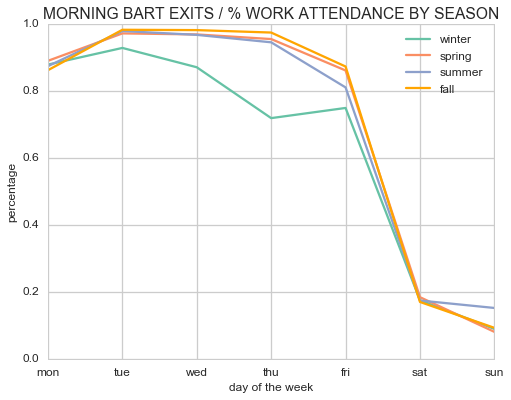

In [126]:
df_predict['20141101':'20150130'].groupby('dayofweek')['counts_normed'].mean().plot(figsize=(8,6), 
                title='Average percentage of work attendance in 2015', fontsize = 12, label='winter')
df_predict['20150201':'20150430'].groupby('dayofweek')['counts_normed'].mean().plot(figsize=(8,6), 
                title='Average percentage of work attendance in 2015', fontsize = 12, label='spring')
df_predict['20150501':'20150730'].groupby('dayofweek')['counts_normed'].mean().plot(figsize=(8,6), 
                title='Average percentage of work attendance in 2015', fontsize = 12, label='summer')
df_predict['20150801':'20151030'].groupby('dayofweek')['counts_normed'].mean().plot(figsize=(8,6), 
                title='MORNING BART EXITS / % WORK ATTENDANCE BY SEASON', fontsize = 12, label='fall', color ='orange')
# df_bart['20110101':'20111231'].groupby('dayofweek')['counts_normed'].mean().plot(figsize=(8,5), 
#                 title='Average percentage of work attendance in 2015', fontsize = 13, label='2011')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['mon','tue','wed','thu','fri','sat','sun'], fontsize=12)
plt.xlabel("day of the week", fontsize=12)
plt.ylabel('percentage', fontsize=12)
plt.legend(fontsize = 12)

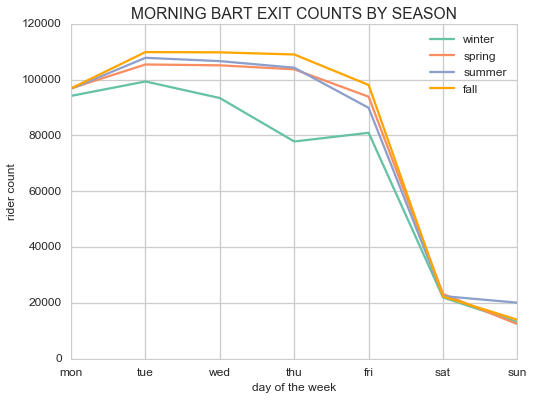

In [127]:
df_predict['20141101':'20150130'].groupby('dayofweek')['counts'].mean().plot(figsize=(8,6), fontsize = 12, label='winter')
df_predict['20150201':'20150430'].groupby('dayofweek')['counts'].mean().plot(figsize=(8,6), fontsize = 12, label='spring')
df_predict['20150501':'20150730'].groupby('dayofweek')['counts'].mean().plot(figsize=(8,6), fontsize = 12, label='summer')
df_predict['20150801':'20151030'].groupby('dayofweek')['counts'].mean().plot(figsize=(8,6), 
                title='MORNING BART EXIT COUNTS BY SEASON', fontsize = 12, label='fall', color ='orange')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['mon','tue','wed','thu','fri','sat','sun'], fontsize=12)
plt.xlabel("day of the week", fontsize=12)
plt.ylabel('rider count', fontsize=12)
plt.legend(fontsize=12)
# 'Average percentage of work attendance in 2015 based on the day of the week. Based on BART exits at Embrcadro, Montgmry, Powell and Civic Ctr from 5a-11a'

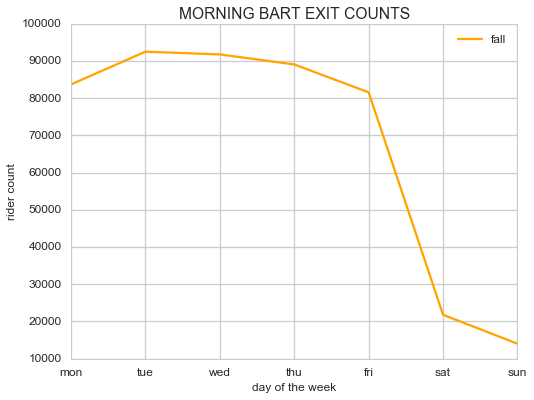

In [128]:
df_predict.groupby('dayofweek')['counts'].mean().plot(figsize=(8,6), 
                title='MORNING BART EXIT COUNTS', fontsize = 12, label='fall', color ='orange')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['mon','tue','wed','thu','fri','sat','sun'], fontsize=12)
plt.xlabel("day of the week", fontsize=12)
plt.ylabel('rider count', fontsize=12)
plt.legend(fontsize=12)
# 'Average percentage of work attendance in 2015 based on the day of the week. Based on BART exits at Embrcadro, Montgmry, Powell and Civic Ctr from 5a-11a'

In [130]:
# df_predict['20150104':'20150110']['counts_normed'].plot(figsize=(12,5))
# df_predict['20150111':'20150117']['counts_normed'].plot(figsize=(12,5))
# df_predict['20150118':'20150124']['counts_normed'].plot(figsize=(12,5))
# df_predict['20150125':'20150131']['counts_normed'].plot(figsize=(12,5))
# df_predict['20150201':'20150207']['counts_normed'].plot(figsize=(12,5))
# plt.xticks([0, 1, 2, 3, 4, 5, 6], ['mon','tue','wed','thu','fri','sat','sun'])
# plt.xlabel='day of the week'
# plt.ylabel='percentage'
# plt.legend()
# 'Average percentage of work attendance in 2015 based on the day of the week. Based on BART exits at Embrcadro, Montgmry, Powell and Civic Ctr from 5a-11a'

In [132]:
# df_predict.ix[3:9]['counts_normed'].plot(figsize=(12,5))
# df_predict.ix[9:16]['counts_normed'].plot(figsize=(12,5))

## Pickle Model

In [136]:
timestr = time.strftime("%Y%m%d-%H%M%S")
print timestr

20160509-181840


In [141]:
model = rf

In [142]:
# model = grid_search.best_estimator_

In [143]:
with open('../model/' + timestr + '-model.pkl', 'w') as f:
        pickle.dump(model, f)

## Read Pickled Model

In [145]:
with open('../model/' + timestr + '-model.pkl') as f:
    model = pickle.load(f)

In [147]:
# df_temp = df_train.copy()
# df_temp['predict'] = model.predict(X)
# df_temp['true'] = y
# df_temp[df_temp.true != df_temp.predict]

## Run prediction model

In [92]:
import numpy as np
import pandas as pd
import psycopg2
import json
import forecastio
import datetime, time
import glob
import sqlalchemy
import sql_helper
from sklearn.ensemble import RandomForestRegressor

# load API key
with open('../api/keys/forecastio-api.json') as f:
    data = json.load(f)
    api_key = data['api_key']

# coordinates for Transamerica Pyramid
lat = 37.795184
lng = -122.402764

# pull weather forecast from API
print ('Getting weather forecast.')
forecast = forecastio.load_forecast(api_key, lat, lng)
timestr = time.strftime("%Y%m%d-%H%M%S")

with open('../data/forecastio/api-pull/' + timestr + '-forecastio.json', 'w') as outfile:
    json.dump(forecast.json, outfile)

df_daily = pd.DataFrame(forecast.json['daily']['data'])
df_daily.columns = [x.lower() for x in df_daily.columns]

df_daily = df_daily[['apparenttemperaturemax',
 'apparenttemperaturemin', 'precipintensity',
 'precipintensitymax',  'pressure', 'temperaturemax',
 'temperaturemin', 'time', 'windspeed']]

# update SQL database
engine = create_engine("postgres://postgres@/forecast")
conn = engine.connect()

colnames = ['apparenttemperaturemax', 'apparenttemperaturemin',
           'precipintensity', 'precipintensitymax', 'pressure',
           'temperaturemax', 'temperaturemin', 'time', 'windspeed']

# insert or update new entries
sql_helper.db_update(df_daily, colnames)

conn.close()
engine.dispose()

#load forecast from database


Getting weather forecast.


In [109]:
engine = create_engine("postgres://postgres@/forecast")
conn = engine.connect()

In [318]:
df_predict_import = pd.read_sql('''SELECT *
                                   FROM forecast_daily
                                   ORDER BY time DESC LIMIT 45''', con=engine)


In [319]:
df_predict_import.tail()

,apparenttemperaturemax,apparenttemperaturemin,precipintensity,precipintensitymax,pressure,temperaturemax,temperaturemin,time,windspeed
40,65.06,52.20,NaN,NaN,1023.48,65.06,52.20,1455350400,2.20
41,64.55,51.99,NaN,NaN,1021.98,64.55,51.99,1455264000,3.35
42,66.20,54.93,NaN,NaN,1020.12,66.20,54.93,1455177600,1.99
43,65.34,53.27,NaN,NaN,1022.19,65.34,53.27,1455091200,1.37
44,67.48,55.18,NaN,NaN,1021.32,67.48,55.18,1455004800,5.44


In [320]:
# df_predict_import['time'] = pd.to_datetime(df_predict_import['time'], unit='s')

In [465]:
df_predict = data_processing.clean_data(df_predict_import)

In [466]:
df_predict_import.head()

,apparenttemperaturemax,apparenttemperaturemin,precipintensity,precipintensitymax,pressure,temperaturemax,temperaturemin,time,windspeed
0,65.55,50.95,0.0000,0.0000,1023.50,65.55,50.95,1458802800,6.96
1,62.11,44.25,0.0000,0.0000,1022.81,62.11,47.52,1458716400,5.91
2,58.55,45.47,0.0021,0.0064,1020.73,58.55,49.09,1458630000,11.68
3,60.68,54.27,0.0142,0.0330,1016.64,60.68,54.27,1458543600,13.48
4,64.77,53.97,0.0040,0.0145,1017.31,64.77,53.97,1458457200,7.57


In [467]:
df = data_processing.predict(df_predict)

In [468]:
df.tail(8)

,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,holiday,apparenttemperaturemax-3,apparenttemperaturemax-7,apparenttemperaturemin-3,apparenttemperaturemin-7,windspeed-3,windspeed-7,predict,slack
time,,,,,,,,,,,,,,,,
2016-03-17,1013.80,68.83,52.95,2.38,3,77,11,0,64.77,65.55,53.97,50.95,7.57,6.96,0.948205,0.051795
2016-03-18,1015.33,65.57,50.03,7.23,4,78,11,0,60.68,0.00,54.27,0.00,13.48,0.00,0.775099,0.224901
2016-03-19,1017.67,66.00,51.94,4.21,5,79,11,0,58.55,0.00,45.47,0.00,11.68,0.00,0.205210,0.794790
2016-03-20,1017.31,64.77,53.97,7.57,6,80,11,0,62.11,0.00,44.25,0.00,5.91,0.00,0.071850,0.928150
2016-03-21,1016.64,60.68,54.27,13.48,0,81,12,0,65.55,0.00,50.95,0.00,6.96,0.00,0.886418,0.113582
2016-03-22,1020.73,58.55,49.09,11.68,1,82,12,0,0.00,0.00,0.00,0.00,0.00,0.00,0.947926,0.052074
2016-03-23,1022.81,62.11,47.52,5.91,2,83,12,0,0.00,0.00,0.00,0.00,0.00,0.00,0.951194,0.048806
2016-03-24,1023.50,65.55,50.95,6.96,3,84,12,0,0.00,0.00,0.00,0.00,0.00,0.00,0.948639,0.051361
